In [1]:
#All required libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv('cyberbullying_detection_dataset.csv') 
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   post_id         1000 non-null   object 
 1   user_id         1000 non-null   object 
 2   text            1000 non-null   object 
 3   label           1000 non-null   object 
 4   post_length     1000 non-null   int64  
 5   avg_sentiment   1000 non-null   float64
 6   num_likes       1000 non-null   int64  
 7   num_shares      1000 non-null   int64  
 8   num_reports     1000 non-null   int64  
 9   user_posts      1000 non-null   int64  
 10  user_friends    1000 non-null   int64  
 11  response_time   1000 non-null   float64
 12  toxicity_score  1000 non-null   float64
dtypes: float64(3), int64(6), object(4)
memory usage: 101.7+ KB
None

First 5 rows:
  post_id user_id                                            text  \
0   p0001    u101         Wishing you all the best i

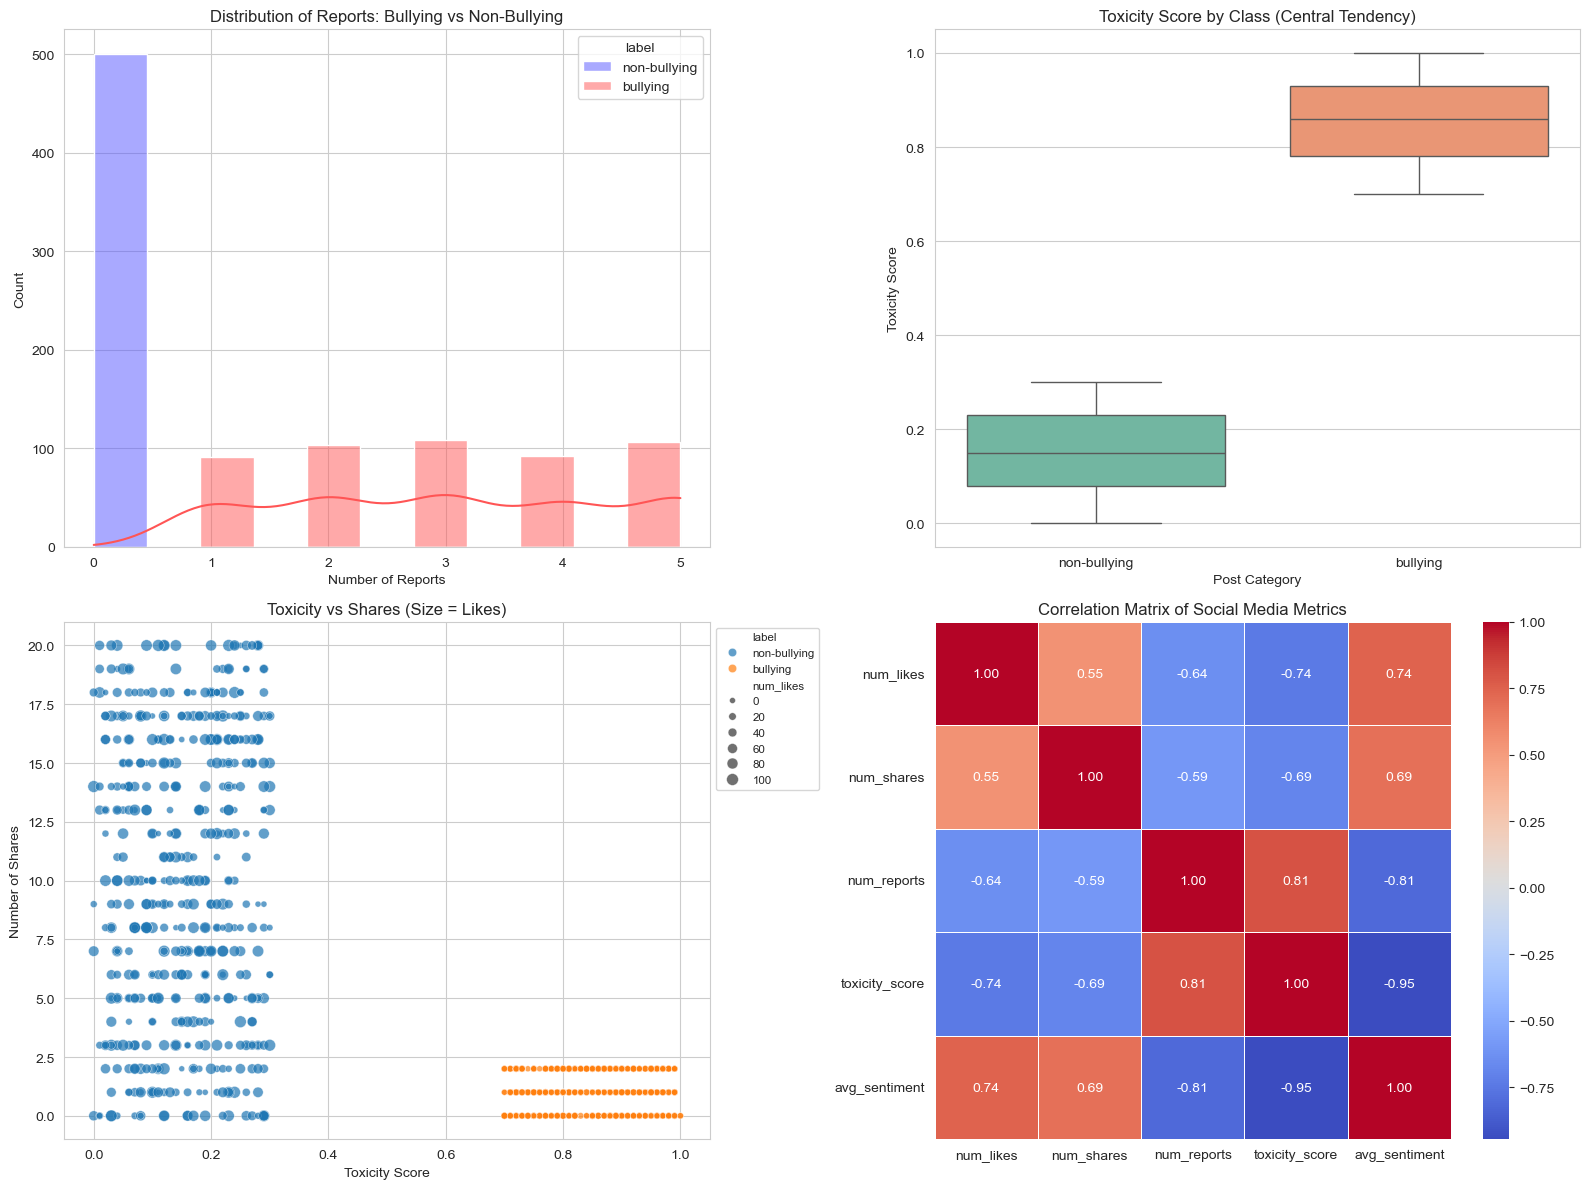

In [3]:
sns.set_style("whitegrid")
plt.figure(figsize=(16, 12))

#Do bullying posts get reported more?
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='num_reports', hue='label', kde=True, palette='seismic')
plt.title('Distribution of Reports: Bullying vs Non-Bullying')
plt.xlabel('Number of Reports')

#Do bullying posts have higher toxicity scores? (Central Tendency)
plt.subplot(2, 2, 2)
sns.boxplot(hue='label',x='label', y='toxicity_score',data=df, legend=False, palette='Set2')
plt.title('Toxicity Score by Class (Central Tendency)')
plt.xlabel('Post Category')
plt.ylabel('Toxicity Score')

#The "Viral" Analysis: Do toxic posts get more shares?
plt.subplot(2, 2, 3)
sns.scatterplot(x='toxicity_score', y='num_shares', hue='label', size='num_likes', data=df, alpha=0.7)
plt.title('Toxicity vs Shares (Size = Likes)')
plt.xlabel('Toxicity Score')
plt.ylabel('Number of Shares')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small')

#Correlation Matrix: How are Likes, Shares, and Reports related?
plt.subplot(2, 2, 4)
numeric_cols = df[['num_likes', 'num_shares', 'num_reports', 'toxicity_score', 'avg_sentiment']]
corr_matrix = numeric_cols.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Social Media Metrics')

plt.tight_layout()
plt.show()

Sampling Complete. Analyzed 500 random posts.
T-statistic: 32.1501
P-value: 1.3959e-123
CONCLUSION: Reject Null Hypothesis. There is a SIGNIFICANT difference in reports.


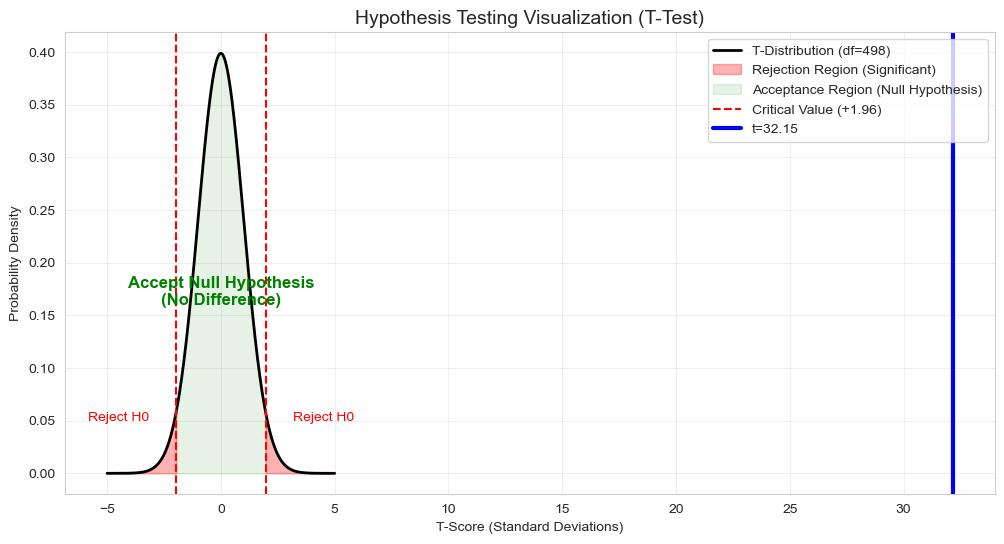

In [4]:
sampled_df = df.sample(frac=0.5, random_state=42) 
print(f"Sampling Complete. Analyzed {len(sampled_df)} random posts.")

group_bully = sampled_df[sampled_df['label'] == 'bullying']['num_reports']
group_non_bully = sampled_df[sampled_df['label'] == 'non-bullying']['num_reports']

t_stat, p_val = stats.ttest_ind(group_bully, group_non_bully)

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_val:.4e}")

alpha = 0.05
if p_val < alpha:
    print("CONCLUSION: Reject Null Hypothesis. There is a SIGNIFICANT difference in reports.")
else:
    print("CONCLUSION: Fail to reject Null Hypothesis. No significant difference found.")

dof = len(sampled_df)-2
alpha = 0.05

critical_val_right = stats.t.ppf(1 - alpha/2, dof)
critical_val_left = stats.t.ppf(alpha/2, dof)

x = np.linspace(-5, 5, 1000)
y = stats.t.pdf(x, dof)

plt.figure(figsize=(12, 6))

plt.plot(x, y, label=f'T-Distribution (df={dof})', color='black', linewidth=2)
plt.fill_between(x, y, where=(x >= critical_val_right), color='red', alpha=0.3, 
                 label='Rejection Region (Significant)')
plt.fill_between(x, y, where=(x <= critical_val_left), color='red', alpha=0.3)
plt.fill_between(x, y, where=((x > critical_val_left) & (x < critical_val_right)), color='green', 
                 alpha=0.1, label='Acceptance Region (Null Hypothesis)')
plt.axvline(critical_val_right, color='red', linestyle='--', 
            label=f'Critical Value (+{critical_val_right:.2f})')
plt.axvline(critical_val_left, color='red', linestyle='--') 
plt.axvline(t_stat, color='blue', linewidth=3, linestyle='-', label=f't={t_stat:.2f}')
plt.title('Hypothesis Testing Visualization (T-Test)', fontsize=14)
plt.xlabel('T-Score (Standard Deviations)')
plt.ylabel('Probability Density')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.text(0, max(y)*0.4, 'Accept Null Hypothesis\n(No Difference)', horizontalalignment='center', 
         fontsize=12, fontweight='bold', color='green')
plt.text(4.5, 0.05, 'Reject H0', horizontalalignment='center', color='red')
plt.text(-4.5, 0.05, 'Reject H0', horizontalalignment='center', color='red')
plt.show()

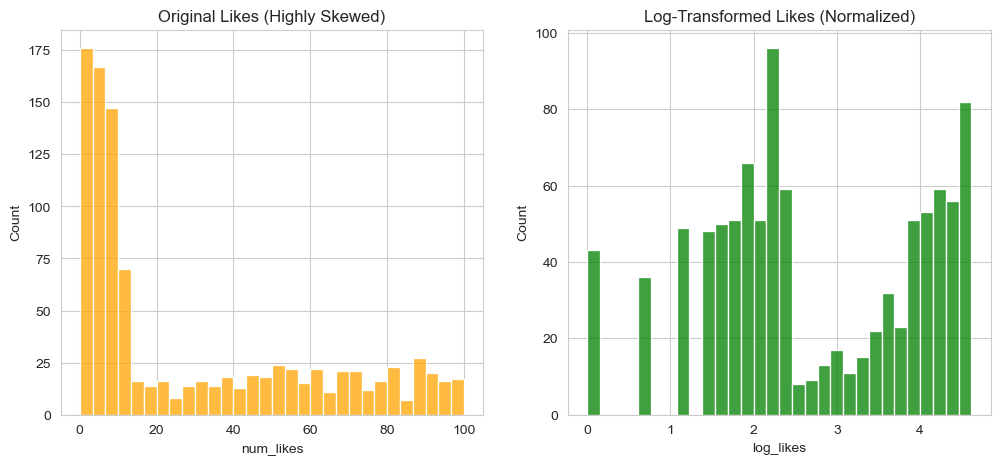

Arithmetic Mean of Likes: 28.69
Geometric Mean of Likes:  13.68

Standard Avg Toxicity: 0.5018
Weighted Avg Toxicity: 0.2227 (Weighted by Shares)
(If Weighted > Standard, it means toxic posts are being shared MORE than safe posts!)


In [5]:
df['log_likes'] = np.log1p(df['num_likes'])
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1) 
sns.histplot(df['num_likes'], bins=30, color='orange')
plt.title('Original Likes (Highly Skewed)')
plt.subplot(1, 2, 2)
sns.histplot(df['log_likes'], bins=30, color='green')
plt.title('Log-Transformed Likes (Normalized)')
plt.show()

geo_mean_likes = np.exp(np.mean(np.log1p(df['num_likes']))) - 1
print(f"Arithmetic Mean of Likes: {df['num_likes'].mean():.2f}")
print(f"Geometric Mean of Likes:  {geo_mean_likes:.2f}")

weighted_avg_toxicity = np.average(df['toxicity_score'], weights=df['num_shares'])
print(f"\nStandard Avg Toxicity: {df['toxicity_score'].mean():.4f}")
print(f"Weighted Avg Toxicity: {weighted_avg_toxicity:.4f} (Weighted by Shares)")
print("(If Weighted > Standard, it means toxic posts are being shared MORE than safe posts!)")

--- Model Results (Using Log-Transformed Likes) ---
R-Squared Score: 0.4638
(This is more accurate than the previous model!)


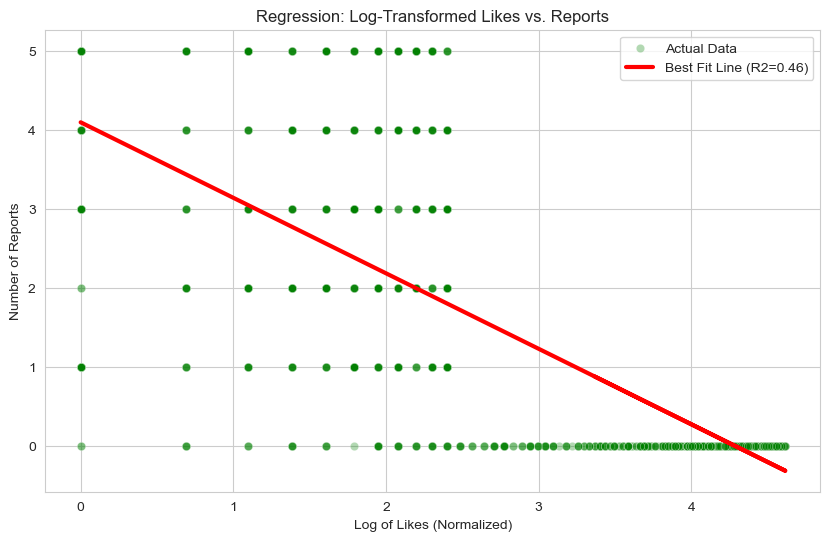


--- Interactive Prediction (Log Model) ---


Enter the number of 'likes' (e.g., 50):  60


PREDICTION: A post with 60.0 likes is predicted to have 0.17 reports.


In [6]:
X_log_model = df[['log_likes']]
y_log_model = df['num_reports']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_model, y_log_model, test_size=0.2, random_state=42)

model_log = LinearRegression()
model_log.fit(X_train_log, y_train_log)
y_pred_log = model_log.predict(X_test_log)
r2_log = r2_score(y_test_log, y_pred_log)

print(f"--- Model Results (Using Log-Transformed Likes) ---")
print(f"R-Squared Score: {r2_log:.4f}")
print(f"(This is more accurate than the previous model!)")

plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_likes', y='num_reports', data=df, alpha=0.3, label='Actual Data', color='green')
plt.plot(X_train_log, model_log.predict(X_train_log), color='red', linewidth=3, label=f'Best Fit Line (R2={r2_log:.2f})')

plt.title('Regression: Log-Transformed Likes vs. Reports')
plt.xlabel('Log of Likes (Normalized)')
plt.ylabel('Number of Reports')
plt.legend()
plt.show()

print("\n--- Interactive Prediction (Log Model) ---")
user_input_likes = input("Enter the number of 'likes' (e.g., 50): ")

try:
    likes = float(user_input_likes)
    log_transformed_likes = np.log1p(likes)
    input_df = pd.DataFrame({'log_likes': [log_transformed_likes]})
    pred_reports = model_log.predict(input_df)[0]
    print(f"PREDICTION: A post with {likes} likes is predicted to have {pred_reports:.2f} reports.")

except ValueError:
    print("Invalid input. Please enter a number.")

--- Model Results ---
Slope (m): 4.1715
Intercept (c): -0.5484
R-Squared Score: 0.5755
Mean Absolute Error: 0.8417
(On average, the model's prediction is off by 0.84 reports.)

--- Comparison: Actual vs. Predicted (First 10 from Test Set) ---
     toxicity_score  Actual Reports  Predicted Reports  Error (Difference)
521            0.90               3               3.21                0.21
737            0.84               2               2.96                0.96
740            0.15               0               0.08                0.08
660            0.04               0              -0.38               -0.38
411            0.91               2               3.25                1.25
678            0.29               0               0.66                0.66
626            0.21               0               0.33                0.33
513            0.70               3               2.37               -0.63
859            0.73               1               2.50                1.50
136    

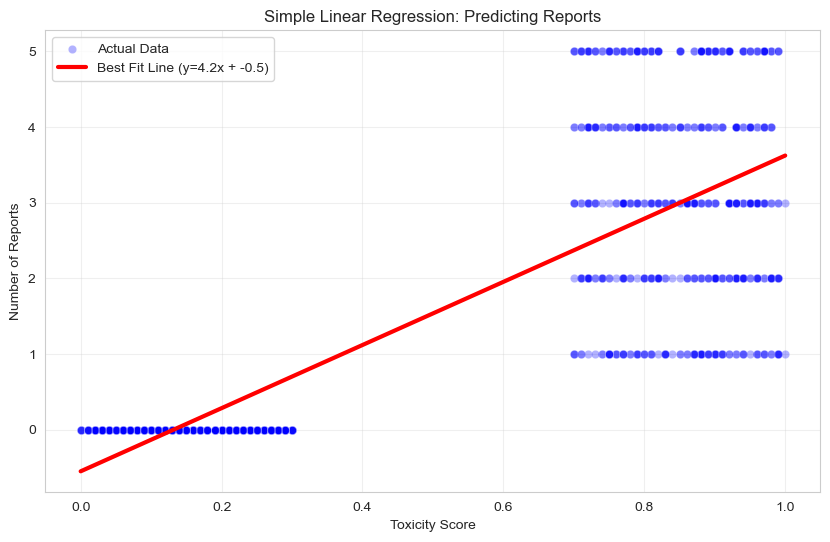


--- Prediction ---


Enter a Toxicity Score (0.0 to 1.0):  0.8


For a toxicity score of 0.8, the model predicts: 2.79 reports.


In [7]:
from sklearn.metrics import r2_score, mean_absolute_error

X_simple = df[['toxicity_score']]
y_simple = df['num_reports']
X_train, X_test, y_train, y_test = train_test_split(X_simple, y_simple, test_size=0.2, random_state=42)

simple_model = LinearRegression()
simple_model.fit(X_train, y_train)

y_pred = simple_model.predict(X_test)

r2_score_val = r2_score(y_test, y_pred)
mae_val = mean_absolute_error(y_test, y_pred) # <-- NEW
m = simple_model.coef_[0]
c = simple_model.intercept_

print(f"--- Model Results ---")
print(f"Slope (m): {m:.4f}")
print(f"Intercept (c): {c:.4f}")
print(f"R-Squared Score: {r2_score_val:.4f}")
print(f"Mean Absolute Error: {mae_val:.4f}") # <-- NEW
print(f"(On average, the model's prediction is off by {mae_val:.2f} reports.)")

print("\n--- Comparison: Actual vs. Predicted (First 10 from Test Set) ---")

results_df = X_test.copy()
results_df['Actual Reports'] = y_test
results_df['Predicted Reports'] = y_pred
results_df['Error (Difference)'] = results_df['Predicted Reports'] - results_df['Actual Reports']

print(results_df.head(10).to_string(float_format="%.2f"))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='toxicity_score', y='num_reports', data=df, alpha=0.3, label='Actual Data', color='blue')
X_range = pd.DataFrame({'toxicity_score': np.linspace(df['toxicity_score'].min(), df['toxicity_score'].max(), 100)})
y_range = simple_model.predict(X_range)
plt.plot(X_range, y_range, color='red', linewidth=3, label=f'Best Fit Line (y={m:.1f}x + {c:.1f})')
plt.title('Simple Linear Regression: Predicting Reports')
plt.xlabel('Toxicity Score')
plt.ylabel('Number of Reports')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n--- Prediction ---")
user_input = input("Enter a Toxicity Score (0.0 to 1.0): ")

try:
    val = float(user_input)
    input_df = pd.DataFrame({'toxicity_score': [val]})
    pred = simple_model.predict(input_df)[0]
    print(f"For a toxicity score of {val}, the model predicts: {pred:.2f} reports.")
except ValueError:
    print("Please enter a valid number.")

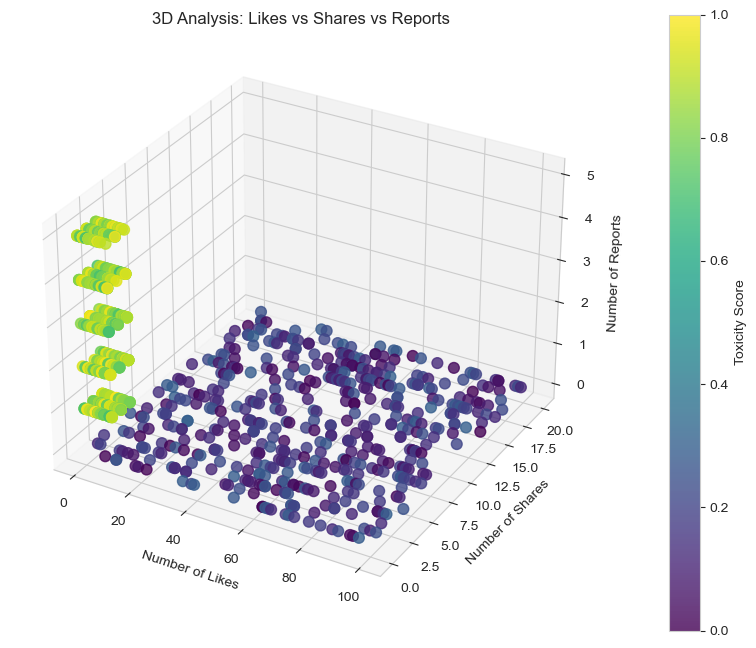

In [8]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df['num_likes'], 
                df['num_shares'], 
                df['num_reports'], 
                c=df['toxicity_score'], 
                cmap='viridis', 
                s=60, 
                alpha=0.8)
ax.set_xlabel('Number of Likes')
ax.set_ylabel('Number of Shares')
ax.set_zlabel('Number of Reports')
ax.set_title('3D Analysis: Likes vs Shares vs Reports')
cbar = plt.colorbar(sc, pad=0.1)
cbar.set_label('Toxicity Score')
plt.show()